# Qexit - Pseudotime analysis for Imaging Data

In [2]:
import sys 
sys.path.append("/mnt/c/Users/azeng/OneDrive/Desktop/Dick_Lab/scRNA_HSC/")
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)
import scRNA_toolkit as tk

/home/azeng/miniconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [582]:
yeet = pd.read_csv('Qexit_TP6toTP100_inclPP.csv', delimiter=',')
yeet.iloc[:,yeet.columns.str.contains("_")].set_index("Cell_ID").T.to_csv("Qexit_gem_TP6toTP100_inclPP.csv")
yeet[['Cell_ID', 'Timepoint', 'Population', 'Specimen']].set_index("Cell_ID").to_csv("Qexit_anno_TP6toTP100_inclPP.csv")

# Dimensionality Reduction

In [914]:
dat = sc.read_csv('Qexit_gem_TP6toTP100_inclPP.csv', delimiter=',')
dat = ad.AnnData.transpose(dat)
dat.obs = pd.read_csv('Qexit_anno_TP6toTP100_inclPP.csv', delimiter=',').rename(columns={"index":"Cell_ID"}).set_index('Cell_ID')
dat.obs['TP'] = dat.obs['Timepoint'].astype('category')

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([6340020, 6340030], dtype='int64', name='Cell_ID'). 


In [915]:
dat = dat[:,dat.var_names.isin(['DAPInucl_IntDen', 'H4K16ac_nucl_IntDen', 'PAK4_IntDen', 'PAK4nucl_IntDen', 'CDK6_IntDen', 'CDK6nucl_IntDen'])]
dat

View of AnnData object with n_obs × n_vars = 3453 × 6 
    obs: 'Timepoint', 'Population', 'Specimen', 'TP'

#### Keeping it simple: 
remove the pcArea and remove the non nuclear. 

In [916]:
sc.pp.log1p(dat)

/home/azeng/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
Transforming to str index.


In [917]:
dat.obs['CDK6_IntDen'] = dat.X[:,np.where(dat.var.index == "CDK6_IntDen")].flatten()
dat.obs['CDK6nucl_IntDen'] = dat.X[:,np.where(dat.var.index == "CDK6nucl_IntDen")].flatten()
dat.obs['DAPInucl_IntDen'] = dat.X[:,np.where(dat.var.index == "DAPInucl_IntDen")].flatten()
dat.obs['H4K16ac_nucl_IntDen'] = dat.X[:,np.where(dat.var.index == "H4K16ac_nucl_IntDen")].flatten()
dat.obs['PAK4_IntDen'] = dat.X[:,np.where(dat.var.index == "PAK4_IntDen")].flatten()
dat.obs['PAK4nucl_IntDen'] = dat.X[:,np.where(dat.var.index == "PAK4_IntDen")].flatten()

In [918]:
sc.pp.scale(dat)
dat.X

array([[ 1.7896554 , -1.4940412 ,  1.2183847 ,  1.3248339 , -2.0629077 ,
        -1.4316576 ],
       [ 1.4025867 , -0.08921299,  0.873375  ,  1.2089856 , -0.91612655,
        -0.3966694 ],
       [ 1.2999667 ,  0.41850075,  0.9459437 ,  1.1339732 , -0.7603812 ,
        -0.32064223],
       ...,
       [ 0.46875197,  0.47501165,  0.69775194,  0.70317847,  1.1937143 ,
         1.13998   ],
       [ 0.66908365,  0.3510817 ,  1.347133  ,  0.9880608 ,  1.6225086 ,
         1.3341085 ],
       [ 1.7036161 ,  0.7867123 ,  1.2316308 ,  1.067167  ,  1.7896374 ,
         1.4918115 ]], dtype=float32)

In [935]:
sc.tl.pca(dat)
sc.pp.neighbors(dat)
sc.tl.diffmap(dat)

sc.tl.leiden(dat, resolution = 0.2)

In [ ]:
dat.obsm['X_diffmap'][:,1] = dat.obsm['X_diffmap'][:,1]*-1
dat.obsm['X_diffmap'][:,2] = dat.obsm['X_diffmap'][:,2]*-1

In [987]:
dat.uns['iroot'] = np.flatnonzero(dat.obs['leiden']  == '0')[0]
sc.tl.dpt(dat, n_branchings=0)
dat.obs['dpt_pseudotime'] = 1-dat.obs['dpt_pseudotime']

In [1068]:
dat

AnnData object with n_obs × n_vars = 3453 × 6 
    obs: 'Timepoint', 'Population', 'Specimen', 'TP', 'CDK6_IntDen', 'CDK6nucl_IntDen', 'DAPInucl_IntDen', 'H4K16ac_nucl_IntDen', 'PAK4_IntDen', 'PAK4nucl_IntDen', 'leiden', 'dpt_pseudotime', 'louvain', 'dpt_group', 'DC0', 'DC1', 'DC2', 'TP6', 'TP18', 'TP42', 'TP66', 'TP100', 'Plus-Plus', 'LT-HSC', 'ST-HSC', 'IT90+ HSC', 'IT90- HSC'
    uns: 'pca', 'neighbors', 'diffmap_evals', 'leiden', 'leiden_colors', 'TP_colors', 'Population_colors', 'iroot', 'louvain', 'louvain_colors', 'dpt_group_colors', 'TP6_colors', 'TP18_colors', 'TP42_colors', 'TP66_colors', 'TP100_colors', 'LT-HSC_colors', 'ST-HSC_colors', 'Plus-Plus_colors', 'IT90+ HSC_colors', 'IT90- HSC_colors'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'

In [1069]:
# dat.write_h5ad("Qexit_imaging_dpt.h5ad")

# Checkpoint - Load Here

In [3]:
dat = sc.read_h5ad("Qexit_imaging_dpt.h5ad")

In [4]:
dat.obs['Diffusion Pseudotime'] = dat.obs['dpt_pseudotime']
dat.obs['Pseudotime Group'] = dat.obs['dpt_group']
dat.obs['Population'] = np.where(dat.obs['Population'] == "20", "HPC", dat.obs['Population'])

In [5]:
dpt = dat.copy()

dpt.obs['CDK6'] = dpt.obs['CDK6_IntDen']
dpt.obs['PAK4'] = dpt.obs['PAK4_IntDen']
dpt.obs['DAPI'] = dpt.obs['DAPInucl_IntDen']
dpt.obs['H4K16ac'] = dpt.obs['H4K16ac_nucl_IntDen']


dpt_plot = dpt.obs[["CDK6", "PAK4", "DAPI", "H4K16ac", "dpt_pseudotime"]]

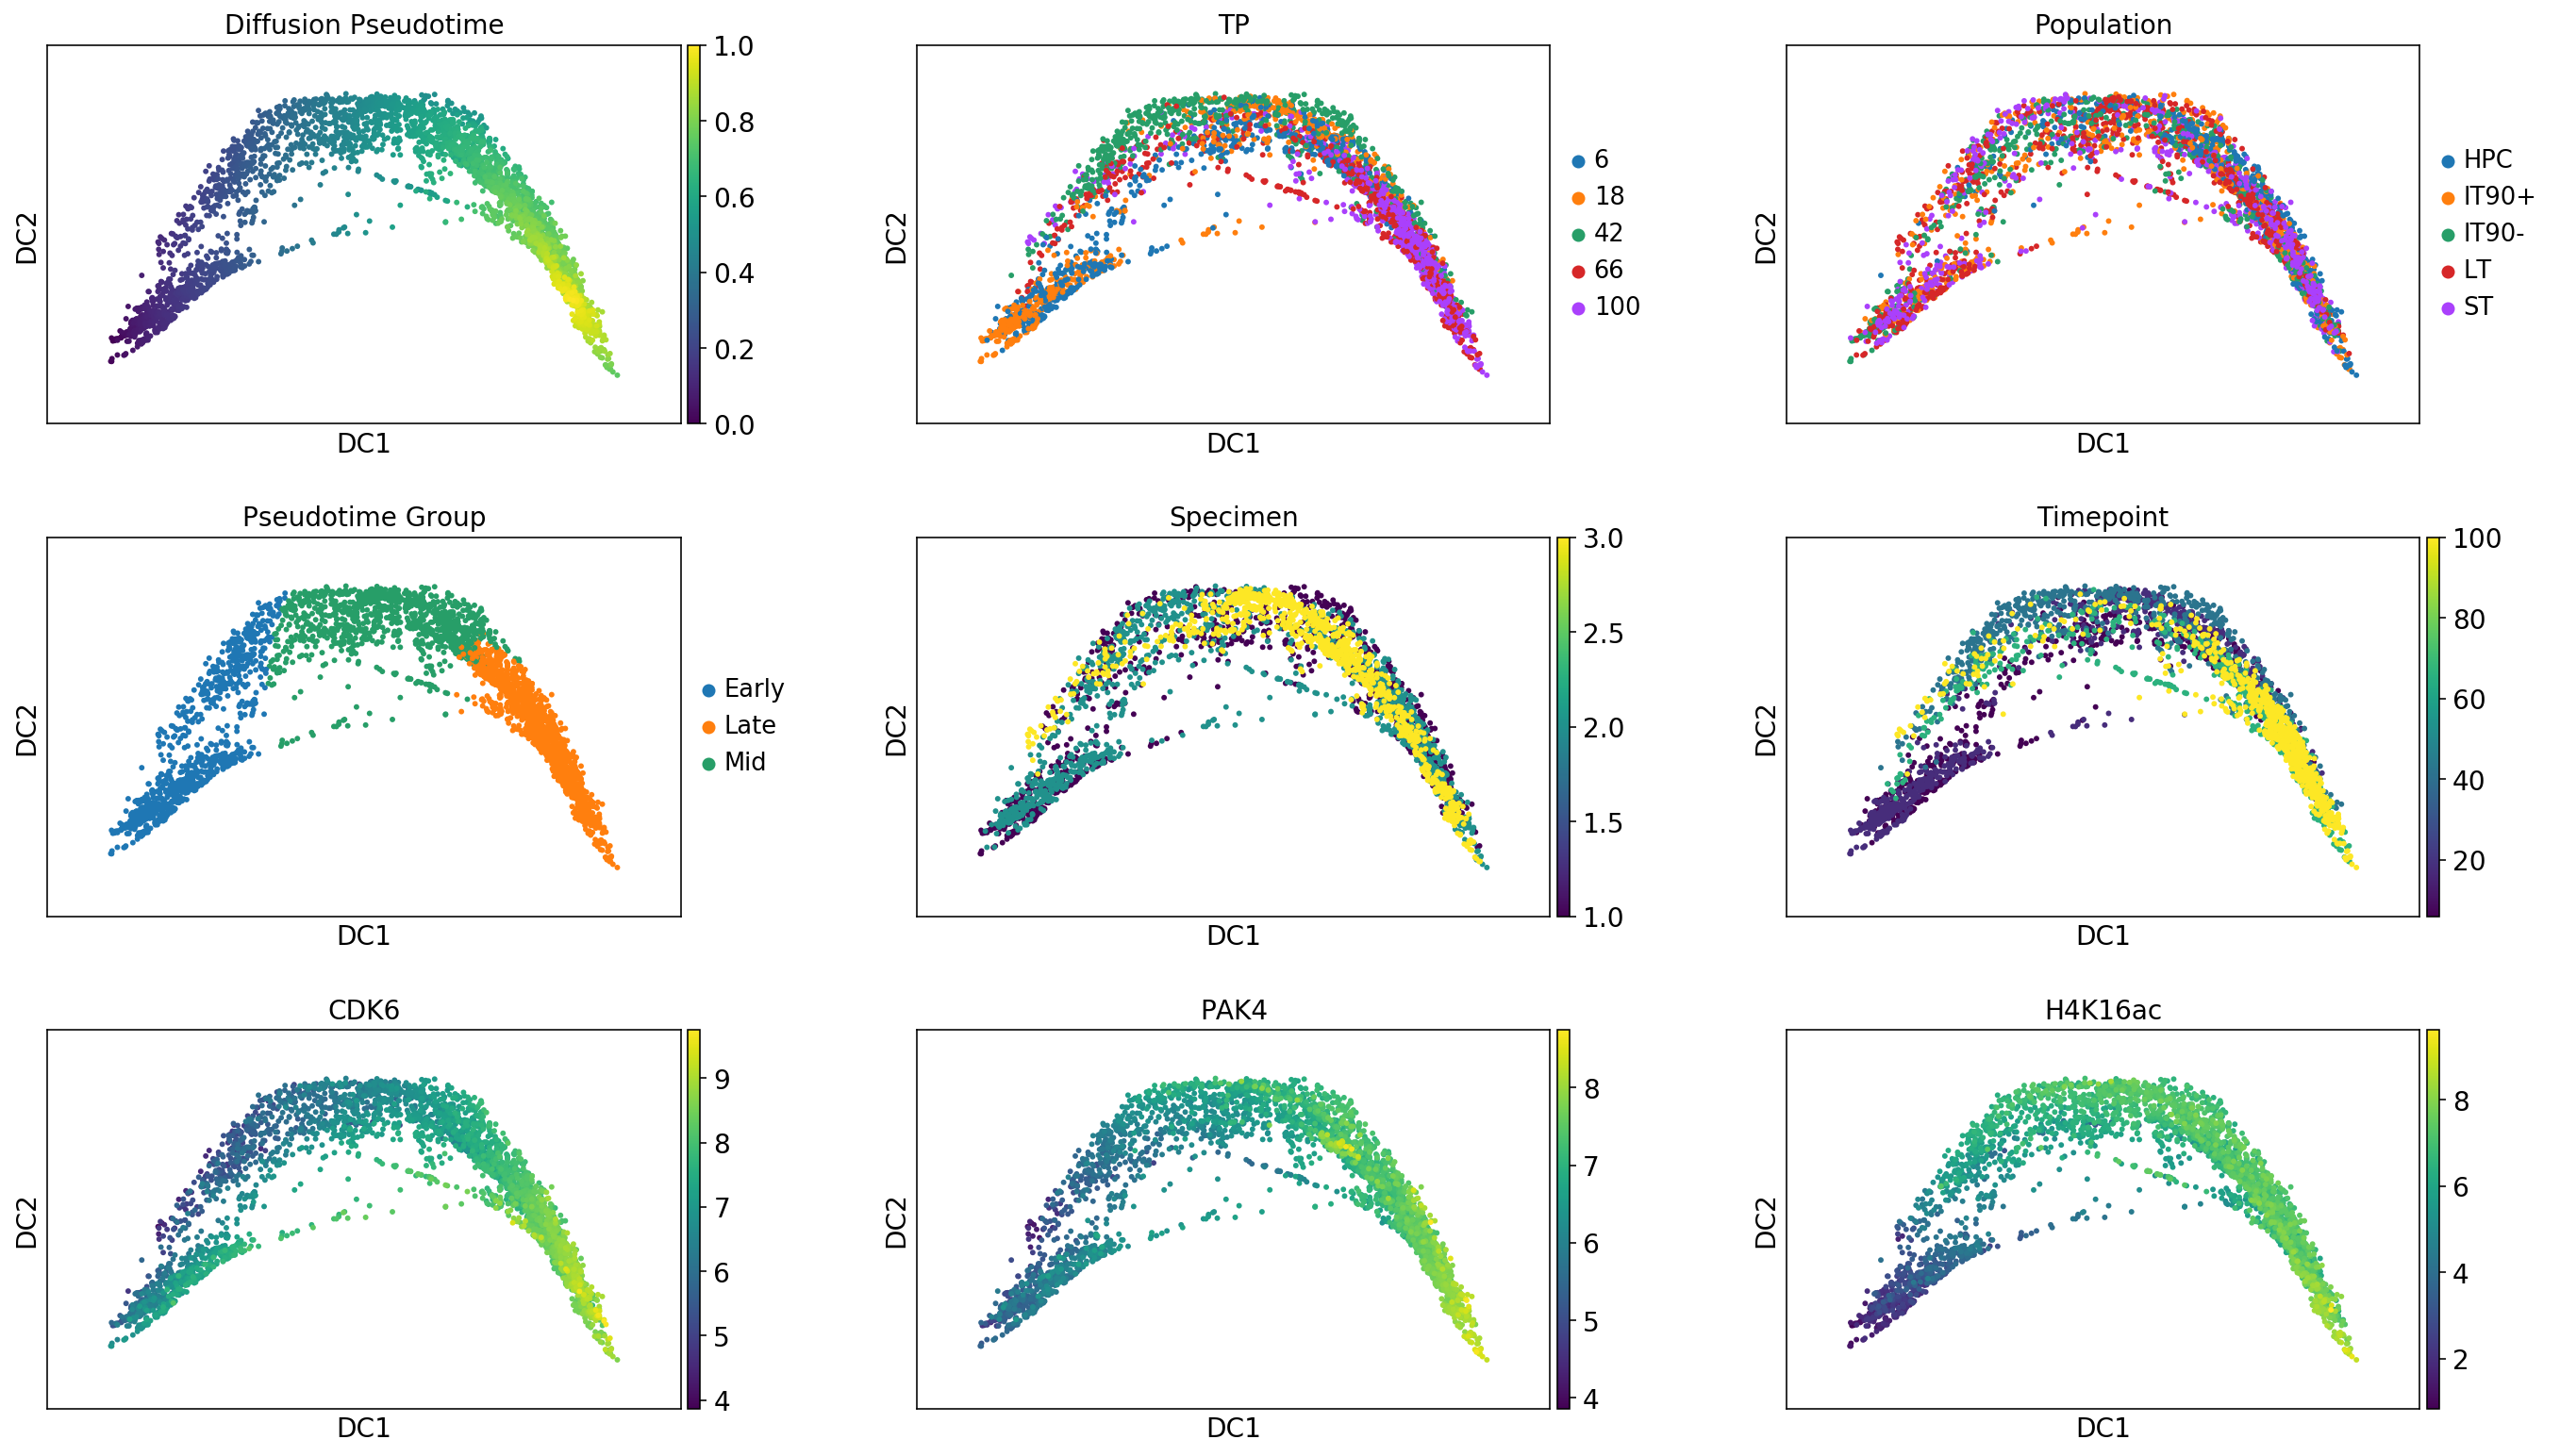

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]

sc.pl.diffmap(dpt, color=['Diffusion Pseudotime', 'TP', 'Population', 
                          'Pseudotime Group', 'Specimen', 'Timepoint', 
                          'CDK6', 'PAK4', 'H4K16ac'], ncols=3, wspace=0.25, hspace=0.3, color_map='viridis', save='Qexit_IF_Diffusion_Maps.png')

## Plot protein flourescence over pseudotime

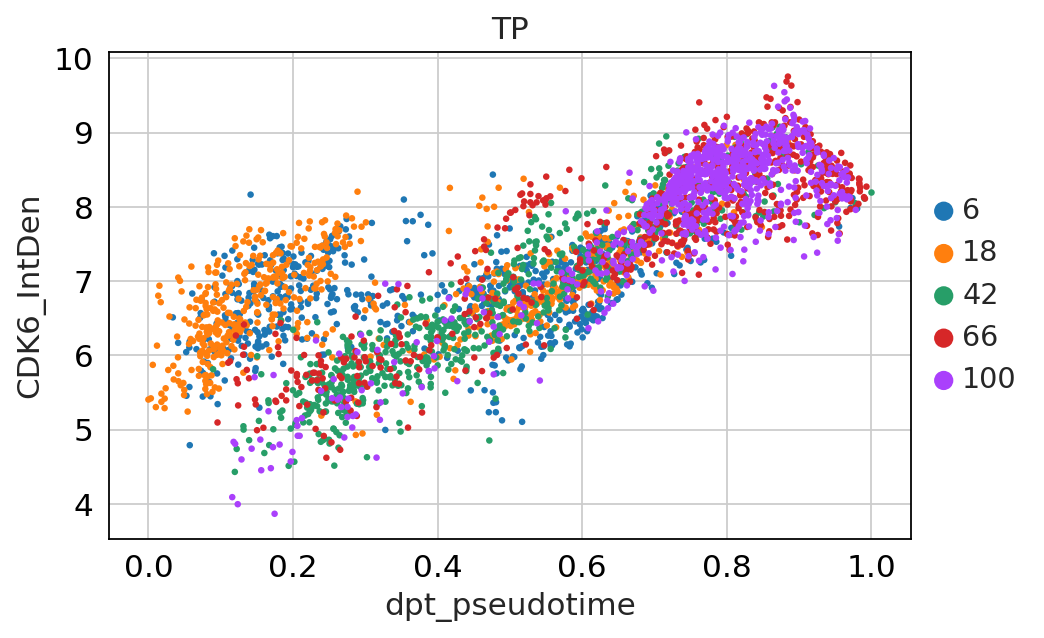

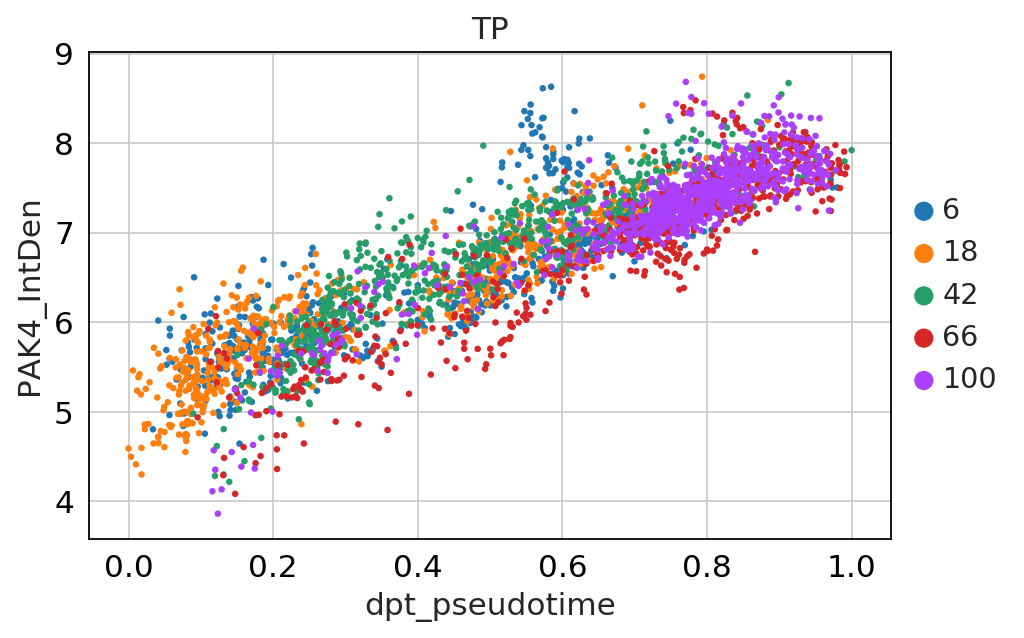

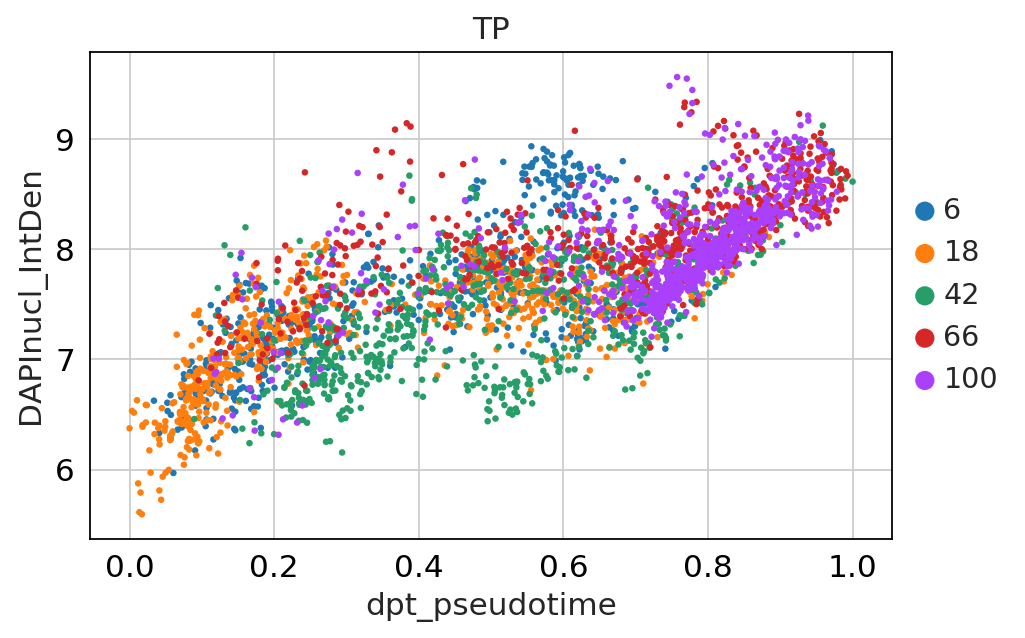

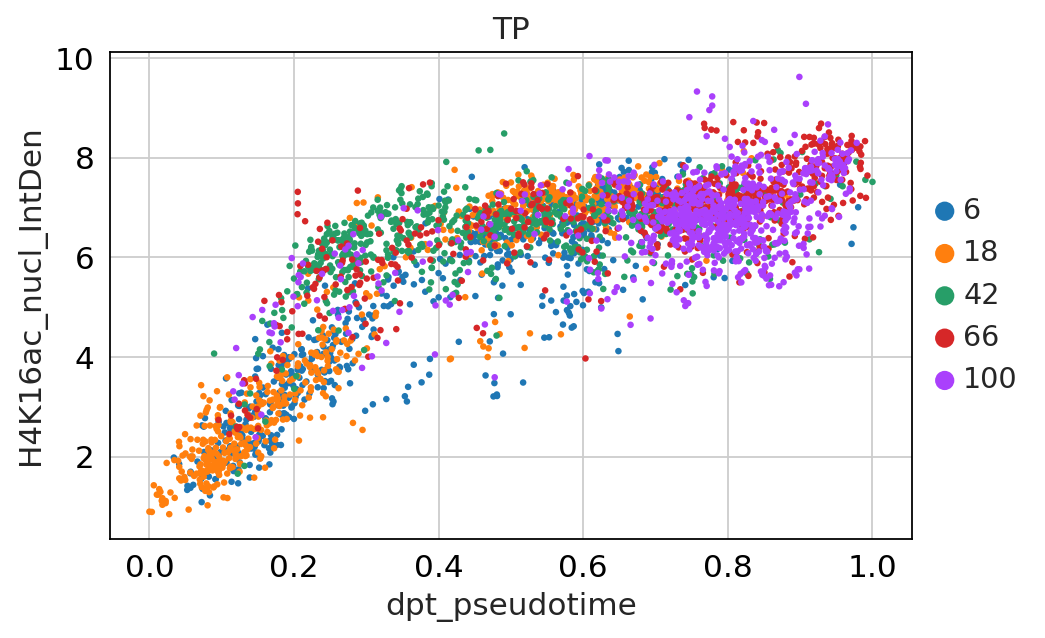

In [994]:
sc.pl.scatter(dat, x='dpt_pseudotime', y='CDK6_IntDen', color='TP')
sc.pl.scatter(dat, x='dpt_pseudotime', y='PAK4_IntDen', color='TP')
sc.pl.scatter(dat, x='dpt_pseudotime', y='DAPInucl_IntDen', color='TP')
sc.pl.scatter(dat, x='dpt_pseudotime', y='H4K16ac_nucl_IntDen', color='TP')

In [963]:
dpt = dat.copy()

dpt.obs['CDK6'] = dpt.obs['CDK6_IntDen']
dpt.obs['PAK4'] = dpt.obs['PAK4_IntDen']
dpt.obs['DAPI'] = dpt.obs['DAPInucl_IntDen']
dpt.obs['H4K16ac'] = dpt.obs['H4K16ac_nucl_IntDen']


dpt_plot = dpt.obs[["CDK6", "PAK4", "DAPI", "H4K16ac", "dpt_pseudotime"]]

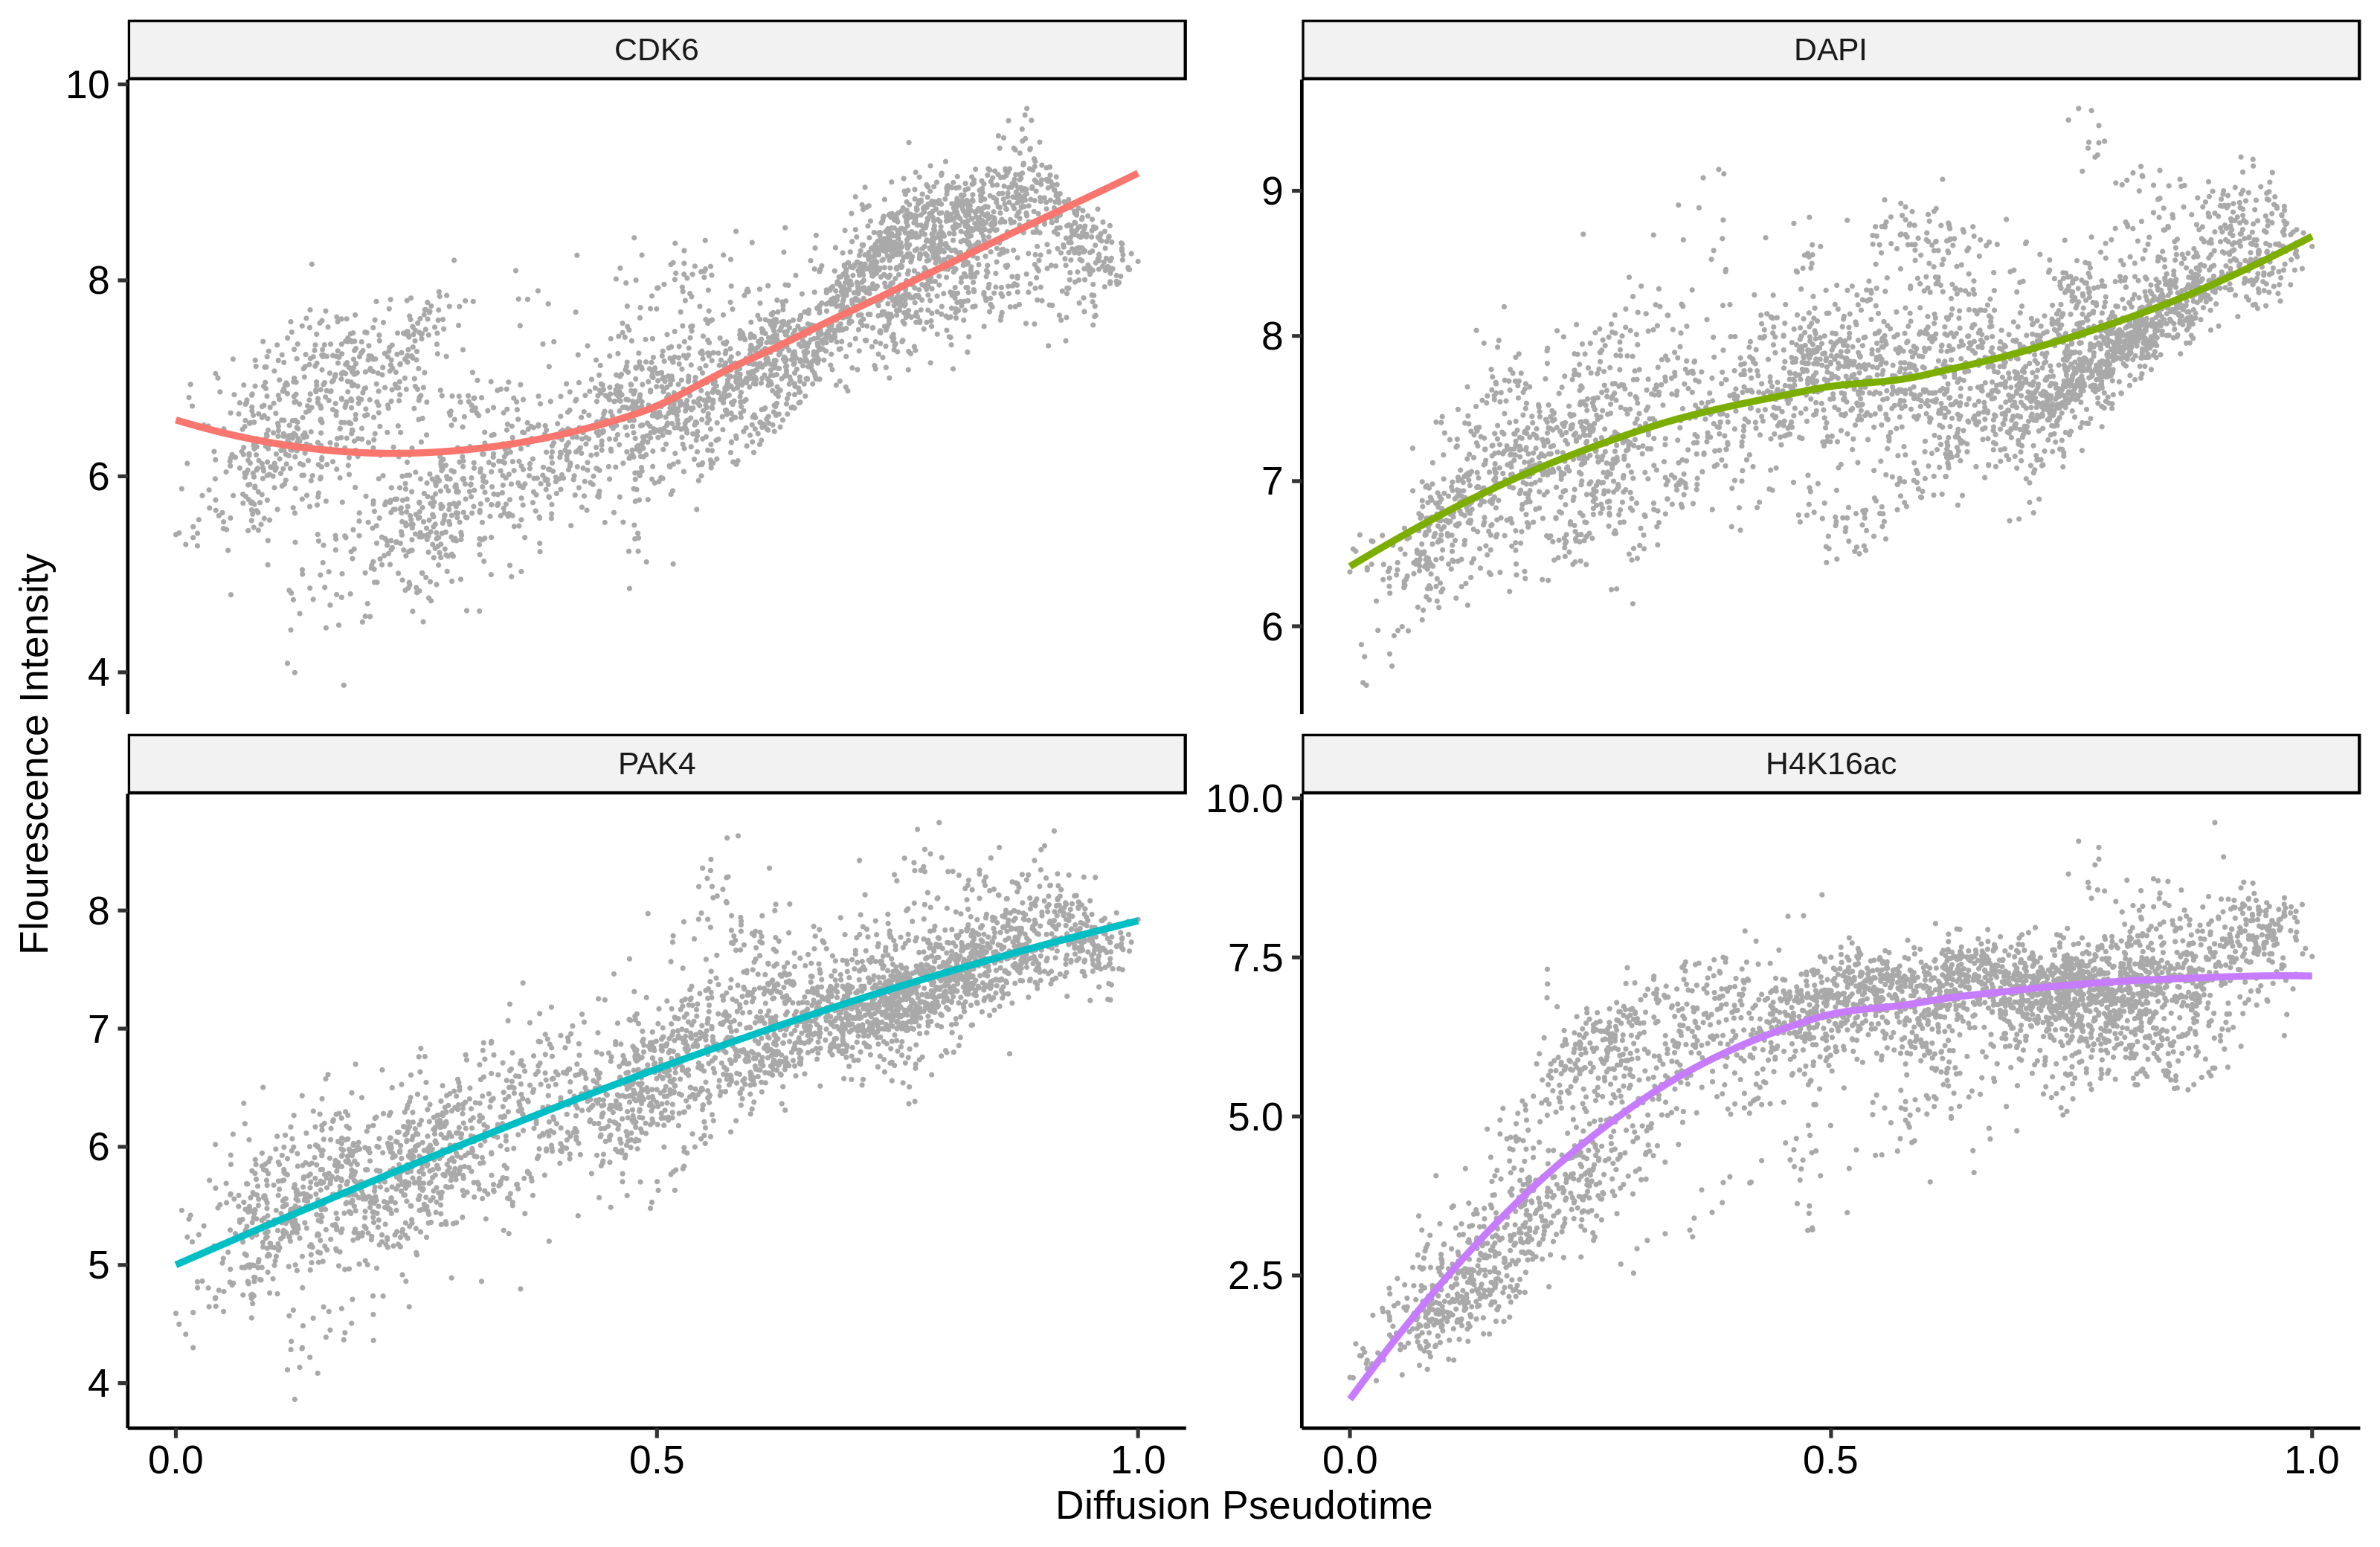

In [982]:
%%R -i dpt_plot -w 10 -h 6.5 --units in -r 320

library(tidyverse)
library(ggpubr)

dpt_plot = dpt_plot %>% gather(key = "gene", value = "scaled_expression", -dpt_pseudotime)

pseudotime = dpt_plot %>% 
    mutate(gene = factor(gene, levels=c("CDK6", "DAPI", "PAK4", "H4K16ac"))) %>% 
    ggplot(aes(x = dpt_pseudotime, y = scaled_expression, color = gene)) +
    geom_point(size=0.1, color='darkgrey') +
    geom_smooth(method = "loess", se = FALSE, span = 1) + 
    facet_wrap(~gene, ncol=2, scale='free_y') +
    theme_pubr() + 
    scale_x_continuous(breaks=c(0,0.5, 1)) + 
    #scale_color_manual(values=c("#7CAE00", "#F75F55", "#00BFC4")) +
    #ylim(-2.9, 3.9) +
    ylab("Flourescence Intensity") +
    xlab("Diffusion Pseudotime") +
    theme(legend.position = "None") 
    
pseudotime + ggsave("figures/Pseudotime_IF_protein_flourescence.png", width = 10, height = 6.5, dpi = 'retina')
print(pseudotime)

In [1057]:
dpt_histos = dat.obs[['dpt_pseudotime', 'TP', 'Population']]
dpt_histos['TP'] = dpt_histos['TP'].astype('str')

/home/azeng/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1022]:
dat.obs['DC0'] = dat.obsm['X_diffmap'][:,0]
dat.obs['DC1'] = dat.obsm['X_diffmap'][:,1]
dat.obs['DC2'] = dat.obsm['X_diffmap'][:,2]

dat.obs.iloc[:,~dat.obs.columns.isin(['leiden', 'louvain', 'DC0'])].to_csv("Qexit_TP6toTP100_Diffusion_Stats.csv")